#### This is the demonstration of the uncalibrated method using the AlexNet backbone and Mendeley V2 dataset.

In [1]:
import torch
import torchvision
from torch.nn import functional as F

import os
import cv2
import numpy as np
from sklearn import metrics
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from model import CNN 
from dataset import DCADataset 
from loss_fn import cross_entropy_with_dca_loss as ce_dca_loss
import utilities as UT


In [2]:
def get_ece(logits, labels, n_bins = 15):
    # This function is based on https://github.com/gpleiss/temperature_scaling
    softmaxes = F.softmax(logits, dim=1)
    confidences, predictions = torch.max(softmaxes, 1)
    accuracies = predictions.eq(labels)
    ece = torch.zeros(1, device=logits.device)

    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    bin_boundaries, bin_lowers, bin_uppers

    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # Calculated |confidence - accuracy| in each bin
        in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
        prop_in_bin = in_bin.float().mean() # weight of current bin            

        if prop_in_bin.item() > 0:        
            accuracy_in_bin = accuracies[in_bin].float().mean()
            avg_confidence_in_bin = confidences[in_bin].mean()    
            ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    
    return ece


def get_mce(logits, labels, n_bins = 15):
    # This function is based on https://github.com/gpleiss/temperature_scaling
    softmaxes = F.softmax(logits, dim=1)
    confidences, predictions = torch.max(softmaxes, 1)
    accuracies = predictions.eq(labels)
    mce = torch.zeros(1, device=logits.device)

    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    bin_boundaries, bin_lowers, bin_uppers

    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # Calculated |confidence - accuracy| in each bin
        in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
        prop_in_bin = in_bin.float().mean()            

        if prop_in_bin.item() > 0:        
            accuracy_in_bin = accuracies[in_bin].float().mean()
            avg_confidence_in_bin = confidences[in_bin].mean()    
            error = torch.abs(avg_confidence_in_bin - accuracy_in_bin)
            if(error>mce):
                mce = error
                
    return mce

In [3]:
def train(net, opt, scheduler, BETA):
    t = trange(EPOCHS, desc=' ', leave=True)

    train_hist = []
    test_hist = []
    pred_result = []
    old_acc = 0
    for e in t:    
        y_true = []
        y_pred = []
        test_y_true = []
        test_y_pred = []

        # training
        net.train()
        for step, (img, label, _) in enumerate(dataloader):
            img = img.float().to(device)
            label = label.long().to(device)
            opt.zero_grad()
            out = net(img)
            loss = ce_dca_loss(out, label, weights=LOSS_WEIGHTS.to(device), beta=BETA) # weighted cross-entropy /w DCA
            y_true, y_pred = UT.assemble_labels(step, y_true, y_pred, label, out)
            loss.backward()
            opt.step()
            t.set_description("step: %i, loss: %.4f" %(step, loss.item()))

        acc = float(torch.sum(torch.max(y_pred, 1)[1]==y_true))/ float(len(y_pred))
        auc = metrics.roc_auc_score(y_true.cpu().detach().numpy(), y_pred.cpu().detach().numpy()[:,1])
        f1 = metrics.f1_score(y_true.cpu().detach().numpy(), torch.max(y_pred, 1)[1].cpu().detach().numpy())
        precision = metrics.precision_score(y_true.cpu().detach().numpy(), torch.max(y_pred, 1)[1].cpu().detach().numpy())
        recall = metrics.recall_score(y_true.cpu().detach().numpy(), torch.max(y_pred, 1)[1].cpu().detach().numpy())
        ap = metrics.average_precision_score(y_true.cpu().detach().numpy(), torch.max(y_pred, 1)[1].cpu().detach().numpy()) #average_precision
        ac = torch.mean(torch.max(F.softmax(y_pred, dim=1), 1)[0]) # average predict confidence        
        ece = get_ece(y_pred, y_true)
        mce = get_mce(y_pred, y_true)    

        scheduler.step()

        # testing
        net.eval()
        with torch.no_grad():
            for step, (img, label, _) in enumerate(val_dataloader):
                img = img.float().to(device)
                label = label.long().to(device)
                out = net(img)
                test_loss = ce_dca_loss(out, label, weights=LOSS_WEIGHTS.to(device), beta=BETA)

                test_y_true, test_y_pred = UT.assemble_labels(step, test_y_true, test_y_pred, label, out)

        test_acc = float(torch.sum(torch.max(test_y_pred, 1)[1]==test_y_true))/ float(len(test_y_pred))
        test_auc = metrics.roc_auc_score(test_y_true.cpu().detach().numpy(), test_y_pred.cpu().detach().numpy()[:,1])
        test_f1 = metrics.f1_score(test_y_true.cpu().detach().numpy(), torch.max(test_y_pred, 1)[1].cpu().detach().numpy())
        test_precision = metrics.precision_score(test_y_true.cpu().detach().numpy(), torch.max(test_y_pred, 1)[1].cpu().detach().numpy())
        test_recall = metrics.recall_score(test_y_true.cpu().detach().numpy(), torch.max(test_y_pred, 1)[1].cpu().detach().numpy())
        test_ap = metrics.average_precision_score(test_y_true.cpu().detach().numpy(), torch.max(test_y_pred, 1)[1].cpu().detach().numpy()) #average_precision
        test_ac = torch.mean(torch.max(F.softmax(test_y_pred, dim=1), 1)[0]) # average predict confidence
        test_ece = get_ece(test_y_pred, test_y_true)
        test_mce = get_mce(test_y_pred, test_y_true)

        train_hist.append([loss.item(), acc, auc, f1, precision, recall, ap, ac.item(), ece.item(), mce.item()])        
        test_hist.append([test_loss.item(), test_acc, test_auc, test_f1, test_precision, test_recall, test_ap, test_ac.item(), test_ece.item(), test_mce.item()])

        if(test_acc>old_acc):
            print('Epoch: %d\n  -Train Acc %.4f  -Train AC %.4f  - Train ECE %.4f  - Train MCE %.4f\n  -Val Acc   %.4f  -Val AC   %.4f  - Val ECE   %.4f  - Val MCE   %.4f' 
                  %(e+1, acc, ac, ece, mce, test_acc, test_ac, test_ece, test_mce))
            old_acc = test_acc

    return train_hist, test_hist

In [4]:
FEATURE = 'Alex'
BATCH_SIZE = 64
FEATURE_SHAPE=(256,25,25) 

DATASET = 'Mendeley'
PATH_TRAIN = './Mendeley_train_list.csv'
PATH_TEST = './Mendeley_test_list.csv'
LOSS_WEIGHTS = torch.tensor([0.735, 0.265]) 
NUM_OF_CLASS = 2

GPU = 1
EPOCHS = 21
LR=0.0001
RESIZE = True
PRETRAINED = True
REQUIRES_GRAD = False

device = torch.device('cuda:'+str(GPU) if torch.cuda.is_available() else 'cpu')

dataset = DCADataset(label_file=PATH_TRAIN, 
                     resize=RESIZE, 
                     augmentation=True)
dataloader = torch.utils.data.DataLoader(dataset, 
                                         num_workers=4, 
                                         batch_size=BATCH_SIZE, 
                                         shuffle=True, 
                                         drop_last=True)

val_dataset = DCADataset(label_file=PATH_TEST, 
                         resize=RESIZE, 
                         augmentation=False)
val_dataloader = torch.utils.data.DataLoader(val_dataset, 
                                             num_workers=4, 
                                             batch_size=BATCH_SIZE, 
                                             shuffle=False, 
                                             drop_last=True)


file_name: /data/scratch/gliang/data/lung_xray/Chest_X-Ray_Images_Pneumonia/train/PNEUMONIA/person693_bacteria_2590.jpeg


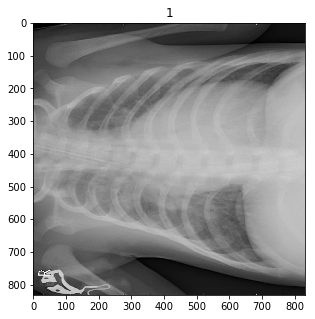

In [5]:
# show one random sample
dataiter = iter(dataloader)    
images, labels, full_path = dataiter.next()
UT.imshow(images, labels, full_path)

### Uncalibrated (Beta=0), EPOCH=100

In [6]:
EPOCHS = 100
BETA=0

net = CNN(num_classes = NUM_OF_CLASS, 
          feature_shape=FEATURE_SHAPE, 
          feature=FEATURE, 
          pretrained=PRETRAINED, 
          requires_grad=REQUIRES_GRAD).float().to(device)
opt = torch.optim.Adam(net.parameters(), lr=LR, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma= 0.985)

train_hist, test_hist = train(net, opt, scheduler, BETA)

step: 80, loss: 0.3359:   1%|          | 1/100 [02:48<4:37:33, 168.22s/it]

Epoch: 1
  -Train Acc 0.7363  -Train AC 0.6574  - Train ECE 0.0789  - Train MCE 0.1198
  -Val Acc   0.8542  -Val AC   0.6663  - Val ECE   0.1892  - Val MCE   0.2458


step: 80, loss: 0.2630:   2%|▏         | 2/100 [05:40<4:37:59, 170.20s/it]

Epoch: 2
  -Train Acc 0.8677  -Train AC 0.6962  - Train ECE 0.1714  - Train MCE 0.2604
  -Val Acc   0.8594  -Val AC   0.6376  - Val ECE   0.2218  - Val MCE   0.2744


step: 80, loss: 0.0180: 100%|██████████| 100/100 [4:52:15<00:00, 175.36s/it] 


In [29]:
train_hist = np.asarray(train_hist)
test_hist = np.asarray(test_hist)

best_epoch = np.argmax(test_hist[:,1])
acc = test_hist[best_epoch,1]
ece = test_hist[best_epoch,8]
mce = test_hist[best_epoch,9]

print('The highest ACC achieved at Epoch:%d\n  - ACC:%.4f\n  - ECE:%.4f\n  - MCE:%.4f' %(best_epoch, acc, ece, mce))

The highest ACC achieved at Epoch:1
  - ACC:0.8594
  - ECE:0.2218
  - MCE:0.2744


ECE, MCE, Loss, and Accuracy for the first 20 epochs:


Text(0.5, 1.0, 'Loss & Accuracy for the first 20 epochs')

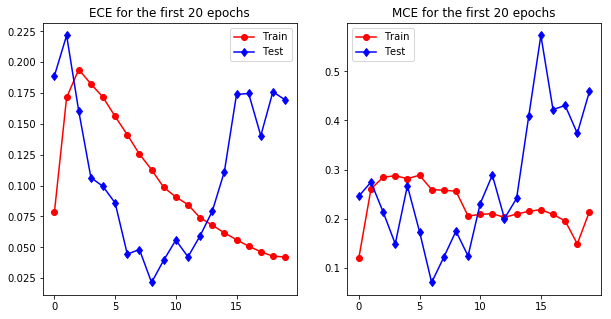

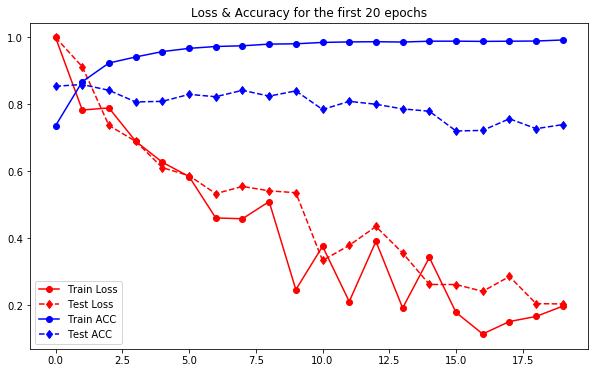

In [35]:
max_epoch=20
print('ECE, MCE, Loss, and Accuracy for the first %d epochs:' %max_epoch)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_hist[:max_epoch,8], 'r-o')
plt.plot(test_hist[:max_epoch,8], 'b-d')
plt.legend(('Train', 'Test'))
plt.title('ECE for the first '+str(max_epoch)+' epochs')
plt.subplot(1,2,2)
plt.plot(train_hist[:max_epoch,9], 'r-o')
plt.plot(test_hist[:max_epoch,9], 'b-d')
plt.legend(('Train', 'Test'))
plt.title('MCE for the first '+str(max_epoch)+' epochs')


plt.figure(figsize=(10,6))
train_loss = train_hist[:max_epoch,0]
train_acc = train_hist[:max_epoch,1]
test_loss = test_hist[:max_epoch,0]
test_acc = test_hist[:max_epoch,1]
train_loss_norm = train_loss/train_loss.max()
test_loss_norm = test_loss/test_loss.max()
plt.plot(train_loss_norm, 'r-o')
plt.plot(test_loss_norm, 'r--d')
plt.plot(train_acc, 'b-o')
plt.plot(test_acc, 'b--d')
plt.legend(('Train Loss', 'Test Loss', 'Train ACC', 'Test ACC'))
plt.title('Loss & Accuracy for the first '+str(max_epoch)+' epochs')

ECE, MCE, Loss, and Accuracy for the first 40 epochs:


Text(0.5, 1.0, 'Loss & Accuracy for the first 40 epochs')

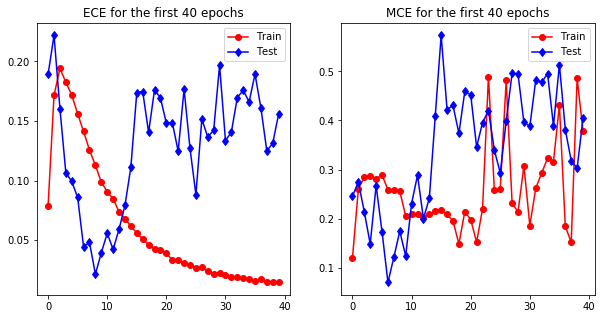

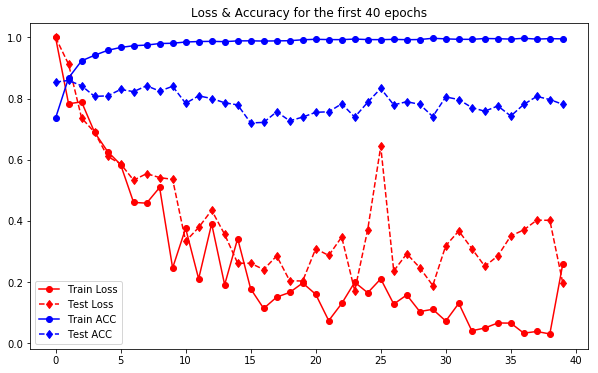

In [36]:
max_epoch=40
print('ECE, MCE, Loss, and Accuracy for the first %d epochs:' %max_epoch)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_hist[:max_epoch,8], 'r-o')
plt.plot(test_hist[:max_epoch,8], 'b-d')
plt.legend(('Train', 'Test'))
plt.title('ECE for the first '+str(max_epoch)+' epochs')
plt.subplot(1,2,2)
plt.plot(train_hist[:max_epoch,9], 'r-o')
plt.plot(test_hist[:max_epoch,9], 'b-d')
plt.legend(('Train', 'Test'))
plt.title('MCE for the first '+str(max_epoch)+' epochs')


plt.figure(figsize=(10,6))
train_loss = train_hist[:max_epoch,0]
train_acc = train_hist[:max_epoch,1]
test_loss = test_hist[:max_epoch,0]
test_acc = test_hist[:max_epoch,1]
train_loss_norm = train_loss/train_loss.max()
test_loss_norm = test_loss/test_loss.max()
plt.plot(train_loss_norm, 'r-o')
plt.plot(test_loss_norm, 'r--d')
plt.plot(train_acc, 'b-o')
plt.plot(test_acc, 'b--d')
plt.legend(('Train Loss', 'Test Loss', 'Train ACC', 'Test ACC'))
plt.title('Loss & Accuracy for the first '+str(max_epoch)+' epochs')

ECE, MCE, Loss, and Accuracy for the first 100 epochs:


Text(0.5, 1.0, 'Loss & Accuracy for the first 100 epochs')

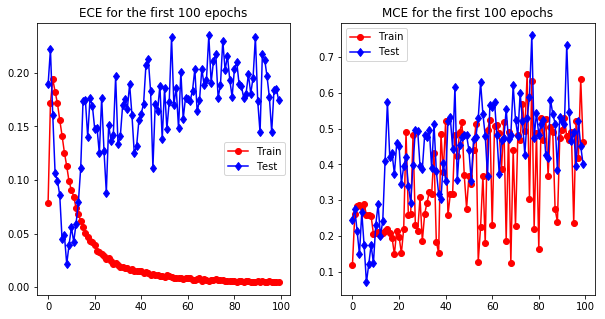

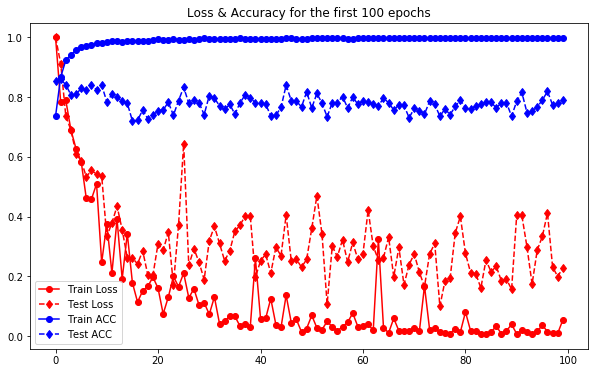

In [34]:
max_epoch=100
print('ECE, MCE, Loss, and Accuracy for the first %d epochs:' %max_epoch)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_hist[:max_epoch,8], 'r-o')
plt.plot(test_hist[:max_epoch,8], 'b-d')
plt.legend(('Train', 'Test'))
plt.title('ECE for the first '+str(max_epoch)+' epochs')
plt.subplot(1,2,2)
plt.plot(train_hist[:max_epoch,9], 'r-o')
plt.plot(test_hist[:max_epoch,9], 'b-d')
plt.legend(('Train', 'Test'))
plt.title('MCE for the first '+str(max_epoch)+' epochs')


plt.figure(figsize=(10,6))
train_loss = train_hist[:max_epoch,0]
train_acc = train_hist[:max_epoch,1]
test_loss = test_hist[:max_epoch,0]
test_acc = test_hist[:max_epoch,1]
train_loss_norm = train_loss/train_loss.max()
test_loss_norm = test_loss/test_loss.max()
plt.plot(train_loss_norm, 'r-o')
plt.plot(test_loss_norm, 'r--d')
plt.plot(train_acc, 'b-o')
plt.plot(test_acc, 'b--d')
plt.legend(('Train Loss', 'Test Loss', 'Train ACC', 'Test ACC'))
plt.title('Loss & Accuracy for the first '+str(max_epoch)+' epochs')